# This notebook:
### plots beaching probability for the entire ocean with contours with temporal ENSO state contrast

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

import matplotlib.colors as mcolors
plt.rcParams.update({'font.size': 18})

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelsize'] = 22

In [3]:
# import undrogued ENSO data
beach = pd.read_csv('ENSO_beach.csv')
unbeach = pd.read_csv('ENSO_unbeach.csv')

In [4]:
# working from the end of 'ENSO_classification.ipynb'
# now, we consider the relative amount of time each drifter trajectory spends in the temporal el nino or la nina regimes. 
# If a drifter trajectory spends more than 80% of time in one regime or the other, we classify that drifter trajectory as an el nino or 
# la nina drifter trajectory, thus grouping our trajectories by temporal ENSO regime. If a drifter trajectory spends less than 80% of time 
# in either regime, then we classify that drifter trajectory as a 'mixed_ENSO' drifter trajectory

In [5]:
def classify_ENSO_trajectories(df, percent_parameter):
    # Group by id and ENSO state to calculate the percent in each group
    value_counts = df.groupby('id')['ENSO'].value_counts(normalize=True) * 100

    # initialize lists
    el_nino_traj = []
    la_nina_traj = []
    mixed_ENSO_traj = []

    # iterate through unique ids
    for ID in value_counts.index.get_level_values(0).unique():
        
        # get percent in el nino and la nina
        percent_el_nino = value_counts.get((ID, 'el nino'), 0)
        percent_la_nina = value_counts.get((ID, 'la nina'), 0)

        # classify id based on percentages
        if percent_el_nino >= percent_parameter:
            el_nino_traj.append(ID)
        elif percent_la_nina >= percent_parameter:
            la_nina_traj.append(ID)
        else:
            mixed_ENSO_traj.append(ID)

    return el_nino_traj, la_nina_traj, mixed_ENSO_traj

In [6]:
# 85 percent seems good
percent_parameter = 85

# beach
el_nino_traj_beach, la_nina_traj_beach, mixed_ENSO_traj_beach = classify_ENSO_trajectories(beach, percent_parameter)

# unbeach
el_nino_traj_unbeach, la_nina_traj_unbeach, mixed_ENSO_traj_unbeach = classify_ENSO_trajectories(unbeach, percent_parameter)

nino ratio: 0.42721634439985406
nina ratio: 0.3269961977186312
mixed ratio: 0.36027126306866347


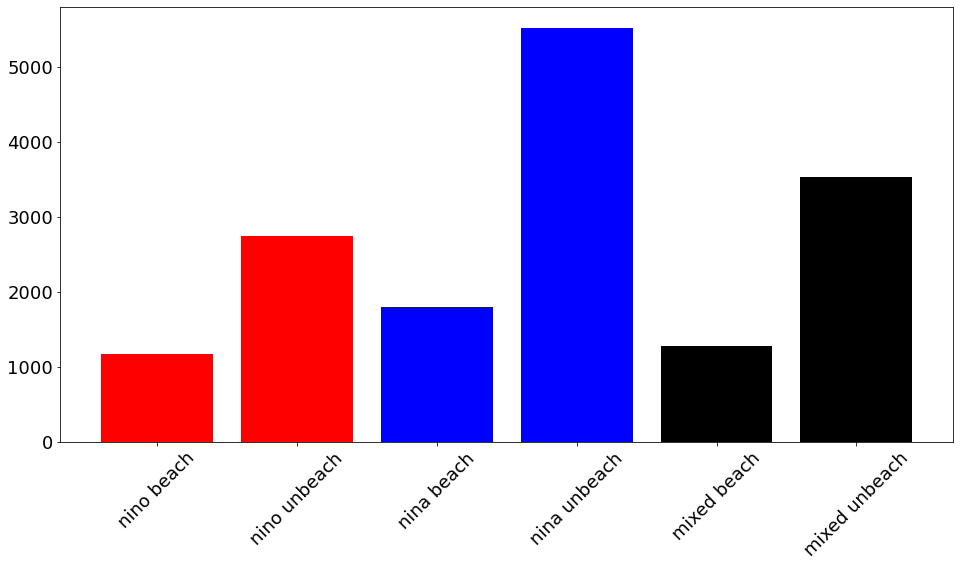

In [7]:
#let's consider their relative sizes:

# find the ratios of beach to unbeach for each:
nino_ratio = len(el_nino_traj_beach) / len(el_nino_traj_unbeach)

nina_ratio = len(la_nina_traj_beach) / len(la_nina_traj_unbeach)

mixed_ratio = len(mixed_ENSO_traj_beach) / len(mixed_ENSO_traj_unbeach)

print('nino ratio: ' + str(nino_ratio))
print('nina ratio: ' + str(nina_ratio))
print('mixed ratio: ' + str(mixed_ratio))


plt.figure(figsize=(16, 8))
colors = ['red', 'red', 'blue', 'blue', 'black', 'black']
plt.bar(["nino beach", "nino unbeach", "nina beach", "nina unbeach", "mixed beach", "mixed unbeach"], 
        [len(el_nino_traj_beach), len(el_nino_traj_unbeach), len(la_nina_traj_beach),len(la_nina_traj_unbeach), 
         len(mixed_ENSO_traj_beach), len(mixed_ENSO_traj_unbeach)], color = colors)

plt.xticks(rotation=45, ha='center') 
plt.show()

nino ratio: 0.42721634439985406
nina ratio: 0.42721634439985406
mixed ratio: 0.42721634439985406


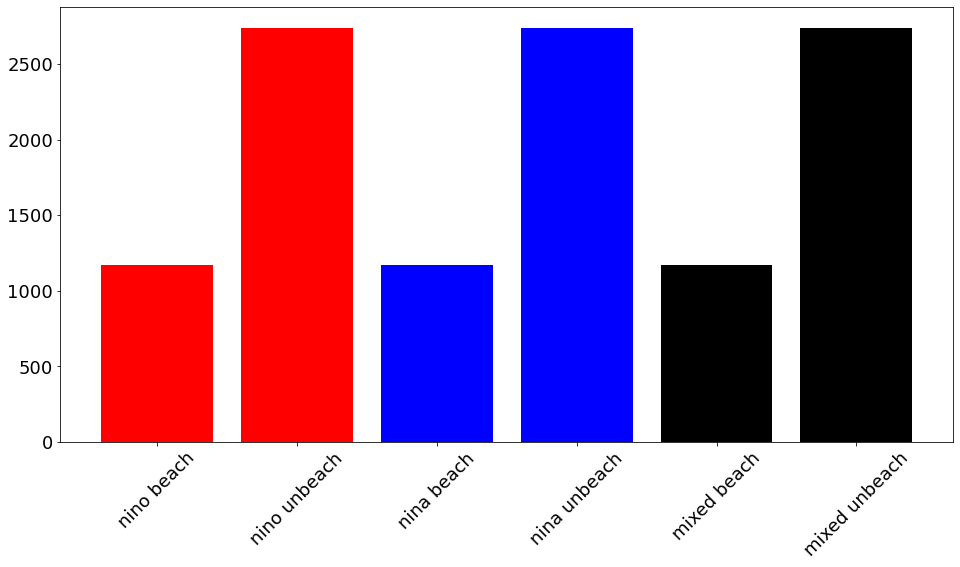

In [8]:
# We should normalize the ratios of beached to unbeached across nino, nina, and mixed so we can effectively compare beaching probabilities
# We sample all ENSO states of both beach and unbeach to the lowest length count in each respective beaching condition.

np.random.seed(42) # the answer to the ultimate question i.e., random results are made reproducible

el_nino_traj_beach_subset = np.random.choice(el_nino_traj_beach, size=1171, replace=False)
el_nino_traj_unbeach_subset = np.random.choice(el_nino_traj_unbeach, size=2741, replace=False)

la_nina_traj_beach_subset = np.random.choice(la_nina_traj_beach, size=1171, replace=False)
la_nina_traj_unbeach_subset = np.random.choice(la_nina_traj_unbeach, size=2741, replace=False)

mixed_ENSO_traj_beach_subset = np.random.choice(mixed_ENSO_traj_beach, size=1171, replace=False)
mixed_ENSO_traj_unbeach_subset = np.random.choice(mixed_ENSO_traj_unbeach, size=2741, replace=False)


# find the ratios of beach to unbeach for each:
nino_ratio = len(el_nino_traj_beach_subset) / len(el_nino_traj_unbeach_subset)

nina_ratio = len(la_nina_traj_beach_subset) / len(la_nina_traj_unbeach_subset)

mixed_ratio = len(mixed_ENSO_traj_beach_subset) / len(mixed_ENSO_traj_unbeach_subset)

print('nino ratio: ' + str(nino_ratio))
print('nina ratio: ' + str(nina_ratio))
print('mixed ratio: ' + str(mixed_ratio))


plt.figure(figsize=(16, 8))
colors = ['red', 'red', 'blue', 'blue', 'black', 'black']
plt.bar(["nino beach", "nino unbeach", "nina beach", "nina unbeach", "mixed beach", "mixed unbeach"], 
        [len(el_nino_traj_beach_subset), len(el_nino_traj_unbeach_subset), len(la_nina_traj_beach_subset),len(la_nina_traj_unbeach_subset), 
         len(mixed_ENSO_traj_beach_subset), len(mixed_ENSO_traj_unbeach_subset)], color = colors)

plt.xticks(rotation=45, ha='center') 
plt.show()

In [9]:
# Beach
# Separate data into nino, nina, mixed based on ID
beach_nino = beach[beach['id'].isin(el_nino_traj_beach_subset)]
beach_nina = beach[beach['id'].isin(la_nina_traj_beach_subset)]
beach_mixed = beach[beach['id'].isin(mixed_ENSO_traj_beach_subset)]

# Unbeach
# Separate data into nino, nina, mixed based on ID
unbeach_nino = unbeach[unbeach['id'].isin(el_nino_traj_unbeach_subset)]
unbeach_nina = unbeach[unbeach['id'].isin(la_nina_traj_unbeach_subset)]
unbeach_mixed = unbeach[unbeach['id'].isin(mixed_ENSO_traj_unbeach_subset)]

# Let's consider beaching trends during EL Nino

In [10]:
# redefine outdated variables
beach_undrogued = beach_nino
unbeach_undrogued = unbeach_nino

# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability
nino_probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


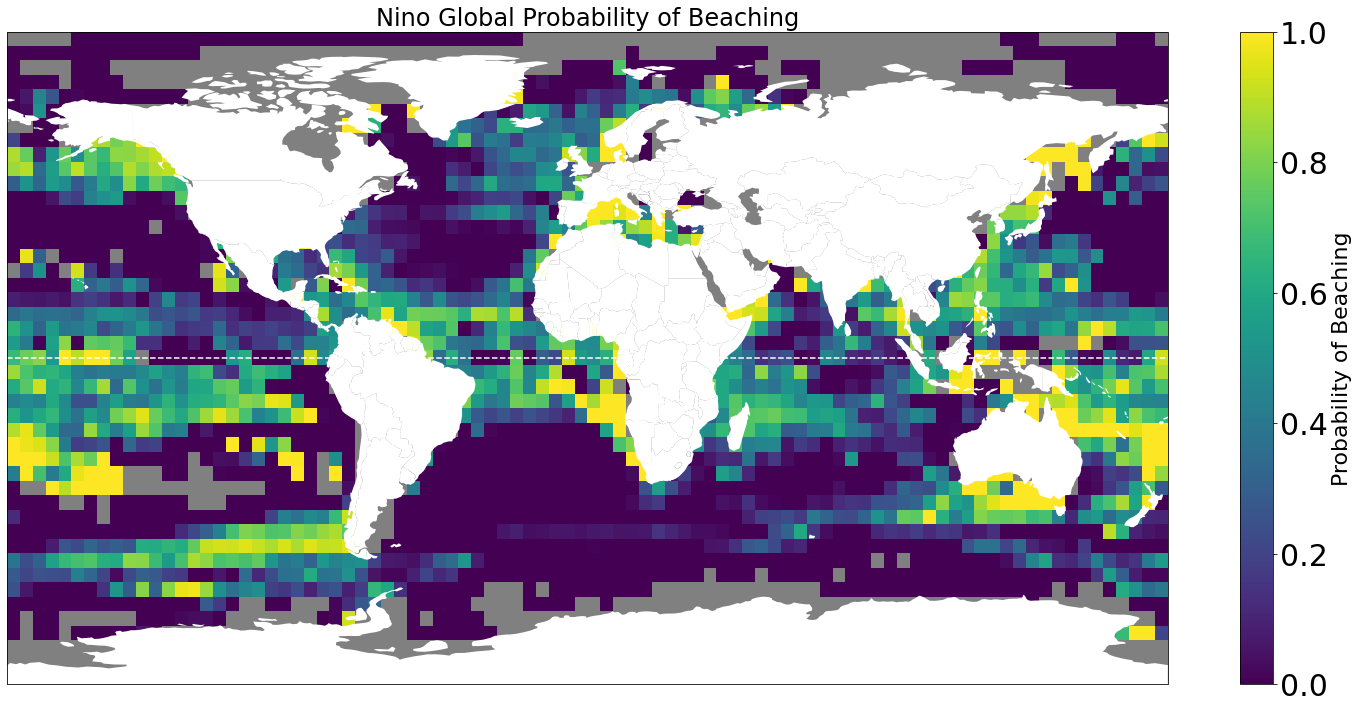

In [11]:
# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(nino_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('Nino Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [12]:
# Define dataframe used:
df_used = beach_nino

# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# Initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

latitudes = []
longitudes = []
latitudes12 = []
longitudes12 = []
latitudes6 = []
longitudes6 = []
latitudes3 = []
longitudes3 = []
latitudes1 = []
longitudes1 = []

for ID in np.unique(df_used['id']):
    trajectory = df_used[df_used['id'] == ID]

    latest_time = max(trajectory['time'])
    start_time = latest_time - 15552000000000  # Full
    start_time12 = latest_time - 31536000  # 12m
    start_time6 = latest_time - 15552000  # 6m
    start_time3 = latest_time - 7890000  # 3m
    start_time1 = latest_time - 2629800  # 1m

    latest_data_all = trajectory[trajectory['time'] <= latest_time]

    latest_data = latest_data_all[latest_data_all['time'] >= start_time]
    latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
    latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
    latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
    latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

    latitudes += list(latest_data['lat'])
    longitudes += list(latest_data['lon'])

    latitudes12 += list(latest_data12['lat'])
    longitudes12 += list(latest_data12['lon'])

    latitudes6 += list(latest_data6['lat'])
    longitudes6 += list(latest_data6['lon'])

    latitudes3 += list(latest_data3['lat'])
    longitudes3 += list(latest_data3['lon'])

    latitudes1 += list(latest_data1['lat'])
    longitudes1 += list(latest_data1['lon'])

# Calculate the 2D histogram (density plot) of point density
heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

# Normalize the data to be in the range [0, 1]
heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2

# Append to previous clusters
heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

# Calculate the 2D histogram (density plot) of point density for 12m
heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

# Calculate the 2D histogram (density plot) of point density for 6m
heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

# Calculate the 2D histogram (density plot) of point density for 3m
heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))

# Calculate the 2D histogram (density plot) of point density for 1m
heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))

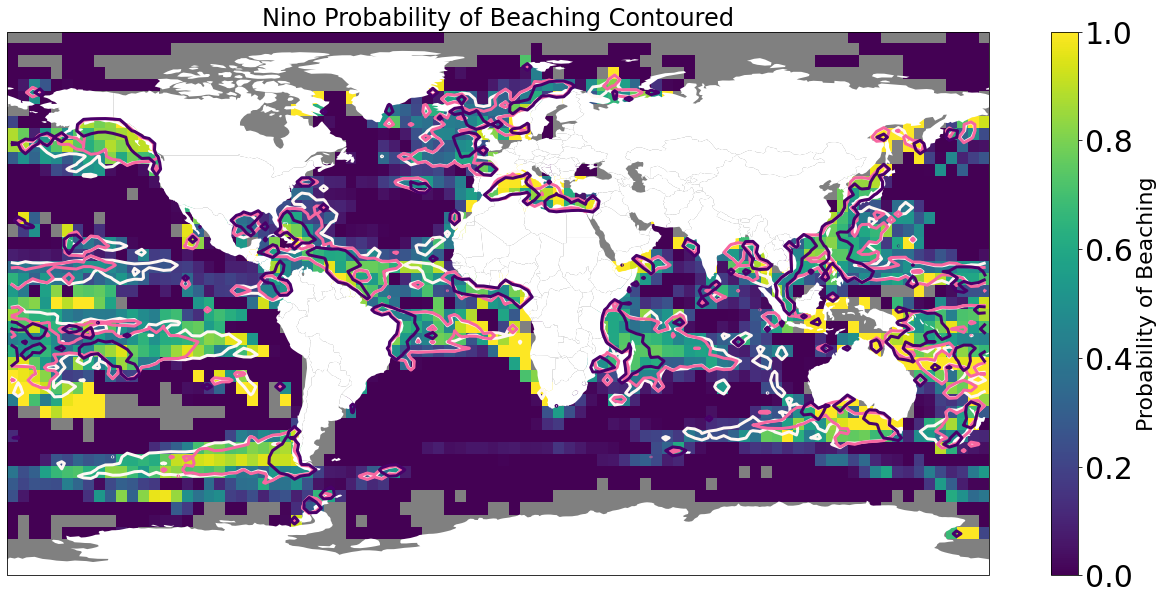

In [13]:
fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# Define the number of contours
num_contours = 3

# Generate a sequence of colors with increasing intensity from a colormap
colors = plt.cm.RdPu(np.linspace(0, 1, num_contours))
#colors = ['white', 'r','b']
#linestyles = ['--', '-.', 'solid']
linestyles = ['solid', 'solid', 'solid']

# Plot contours with specified colors
for data_normalized, color, linestyle in zip([heatmap_data_normalized12,
                                   heatmap_data_normalized6,
                                   heatmap_data_normalized1], colors, linestyles):
    # Add contour lines at the specified level (0.05 in this case)
    contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized,
                          levels=[0.05], colors=[color], linestyles=[linestyle], linewidths=3,
                          transform=ccrs.PlateCarree())

    
# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')
# plot hist on world
mesh = plt.imshow(nino_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(mesh, label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('Nino Probability of Beaching Contoured')

plt.show()

# Let's consider beaching trends during La Nina

In [14]:
# redefine outdated variables
beach_undrogued = beach_nina
unbeach_undrogued = unbeach_nina

# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability
nina_probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


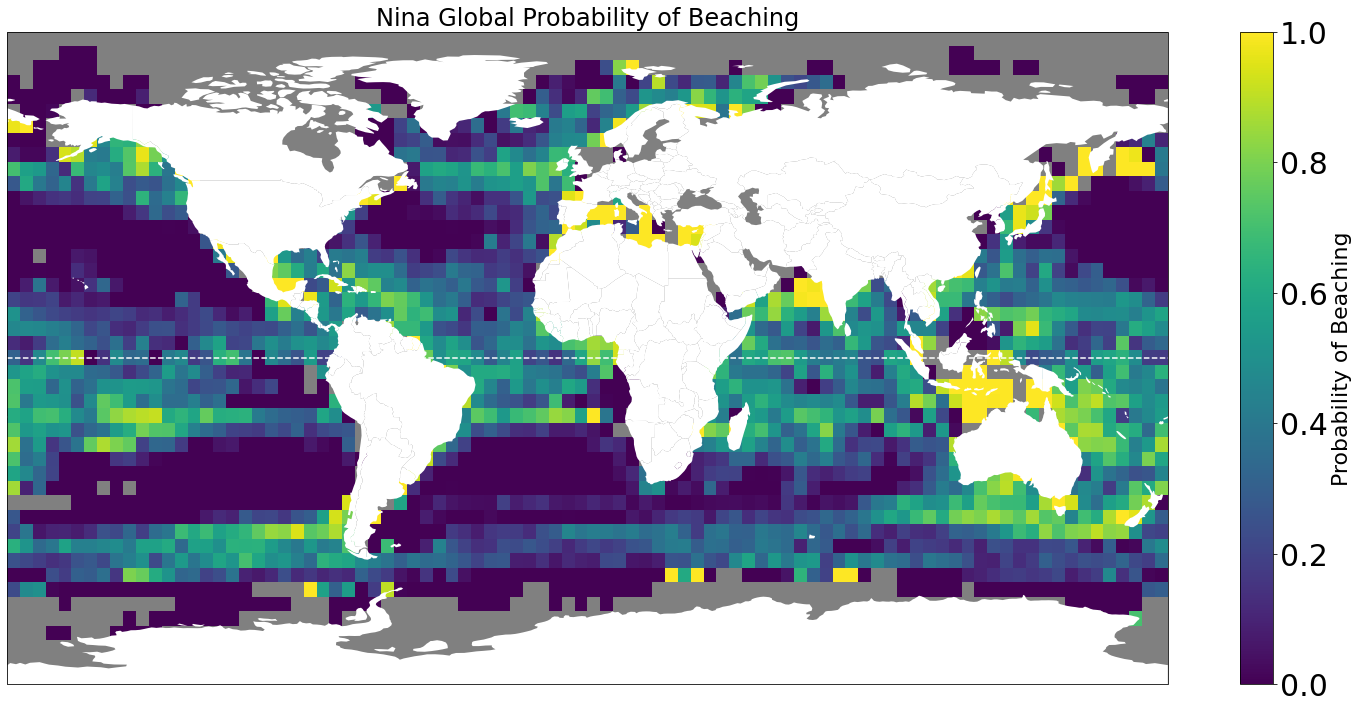

In [15]:
# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(nina_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('Nina Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [16]:
# Define dataframe used:
df_used = beach_nina

# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# Initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

latitudes = []
longitudes = []
latitudes12 = []
longitudes12 = []
latitudes6 = []
longitudes6 = []
latitudes3 = []
longitudes3 = []
latitudes1 = []
longitudes1 = []

for ID in np.unique(df_used['id']):
    trajectory = df_used[df_used['id'] == ID]

    latest_time = max(trajectory['time'])
    start_time = latest_time - 15552000000000  # Full
    start_time12 = latest_time - 31536000  # 12m
    start_time6 = latest_time - 15552000  # 6m
    start_time3 = latest_time - 7890000  # 3m
    start_time1 = latest_time - 2629800  # 1m

    latest_data_all = trajectory[trajectory['time'] <= latest_time]

    latest_data = latest_data_all[latest_data_all['time'] >= start_time]
    latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
    latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
    latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
    latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

    latitudes += list(latest_data['lat'])
    longitudes += list(latest_data['lon'])

    latitudes12 += list(latest_data12['lat'])
    longitudes12 += list(latest_data12['lon'])

    latitudes6 += list(latest_data6['lat'])
    longitudes6 += list(latest_data6['lon'])

    latitudes3 += list(latest_data3['lat'])
    longitudes3 += list(latest_data3['lon'])

    latitudes1 += list(latest_data1['lat'])
    longitudes1 += list(latest_data1['lon'])

# Calculate the 2D histogram (density plot) of point density
heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

# Normalize the data to be in the range [0, 1]
heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2

# Append to previous clusters
heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

# Calculate the 2D histogram (density plot) of point density for 12m
heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

# Calculate the 2D histogram (density plot) of point density for 6m
heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

# Calculate the 2D histogram (density plot) of point density for 3m
heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))

# Calculate the 2D histogram (density plot) of point density for 1m
heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))

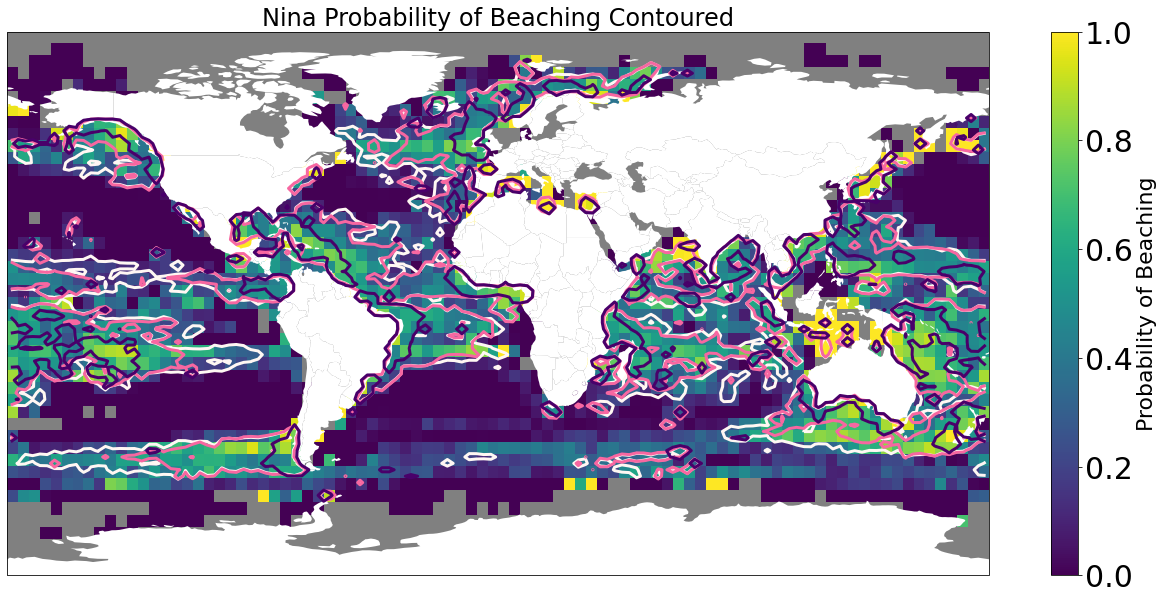

In [17]:
fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# Define the number of contours
num_contours = 3

# Generate a sequence of colors with increasing intensity from a colormap
colors = plt.cm.RdPu(np.linspace(0, 1, num_contours))

# Plot contours with specified colors
for data_normalized, color in zip([heatmap_data_normalized12,
                                   heatmap_data_normalized6,
                                   heatmap_data_normalized1], colors):
    # Add contour lines at the specified level (0.05 in this case)
    contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized,
                          levels=[0.05], colors=[color], linestyles='solid', linewidths=3,
                          transform=ccrs.PlateCarree())

    
# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')
# plot hist on world
mesh = plt.imshow(nina_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(mesh, label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('Nina Probability of Beaching Contoured')

plt.show()

# Let's consider beaching trends during both El Nino and La Nina

In [18]:
# redefine outdated variables
beach_undrogued = beach_mixed
unbeach_undrogued = unbeach_mixed

# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# concatenate them together into single lat/lon lists
lats = np.concatenate((beach_undrogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_undrogued_longs, unbeach_undrogued_longs))

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability
mixed_probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


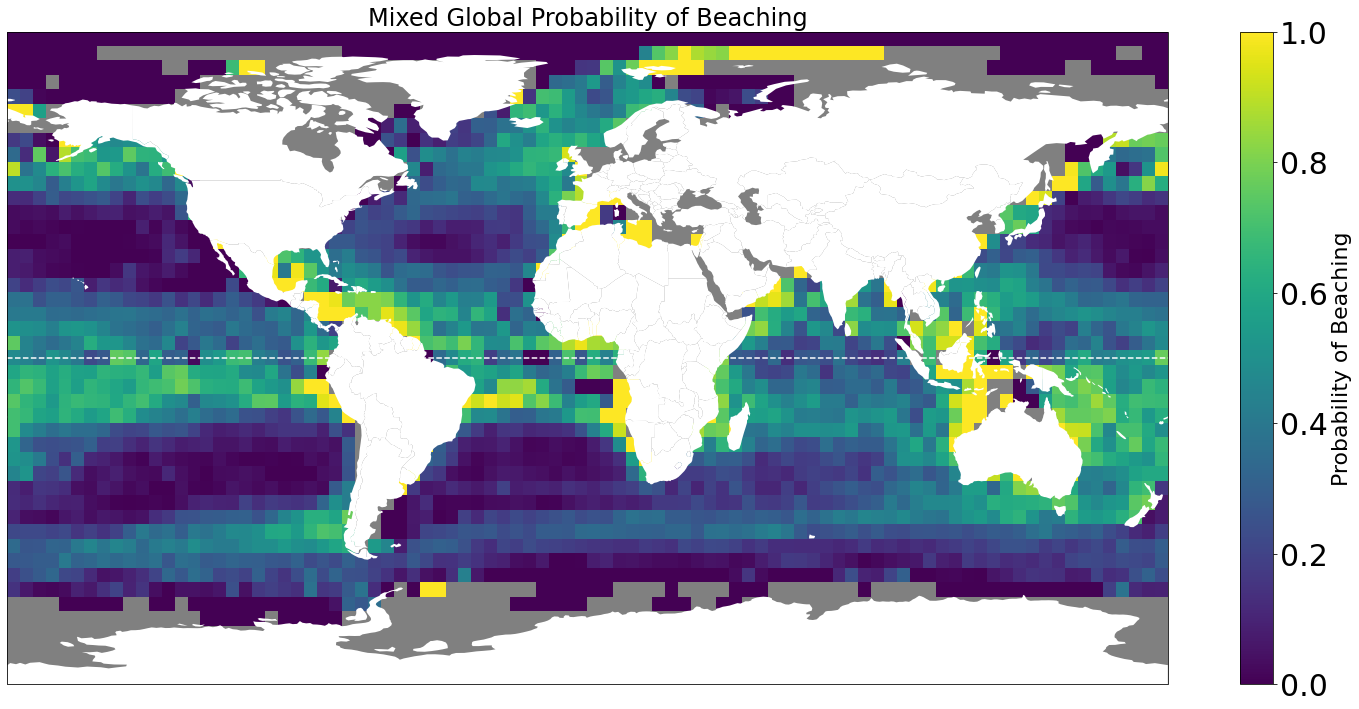

In [19]:
# Given location, probability of beaching
# Undrogued

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(mixed_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('Mixed Global Probability of Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [20]:
# Define dataframe used:
df_used = beach_mixed

# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# Initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

latitudes = []
longitudes = []
latitudes12 = []
longitudes12 = []
latitudes6 = []
longitudes6 = []
latitudes3 = []
longitudes3 = []
latitudes1 = []
longitudes1 = []

for ID in np.unique(df_used['id']):
    trajectory = df_used[df_used['id'] == ID]

    latest_time = max(trajectory['time'])
    start_time = latest_time - 15552000000000  # Full
    start_time12 = latest_time - 31536000  # 12m
    start_time6 = latest_time - 15552000  # 6m
    start_time3 = latest_time - 7890000  # 3m
    start_time1 = latest_time - 2629800  # 1m

    latest_data_all = trajectory[trajectory['time'] <= latest_time]

    latest_data = latest_data_all[latest_data_all['time'] >= start_time]
    latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
    latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
    latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
    latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

    latitudes += list(latest_data['lat'])
    longitudes += list(latest_data['lon'])

    latitudes12 += list(latest_data12['lat'])
    longitudes12 += list(latest_data12['lon'])

    latitudes6 += list(latest_data6['lat'])
    longitudes6 += list(latest_data6['lon'])

    latitudes3 += list(latest_data3['lat'])
    longitudes3 += list(latest_data3['lon'])

    latitudes1 += list(latest_data1['lat'])
    longitudes1 += list(latest_data1['lon'])

# Calculate the 2D histogram (density plot) of point density
heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

# Normalize the data to be in the range [0, 1]
heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2

# Append to previous clusters
heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

# Calculate the 2D histogram (density plot) of point density for 12m
heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

# Calculate the 2D histogram (density plot) of point density for 6m
heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

# Calculate the 2D histogram (density plot) of point density for 3m
heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))

# Calculate the 2D histogram (density plot) of point density for 1m
heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)
heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))

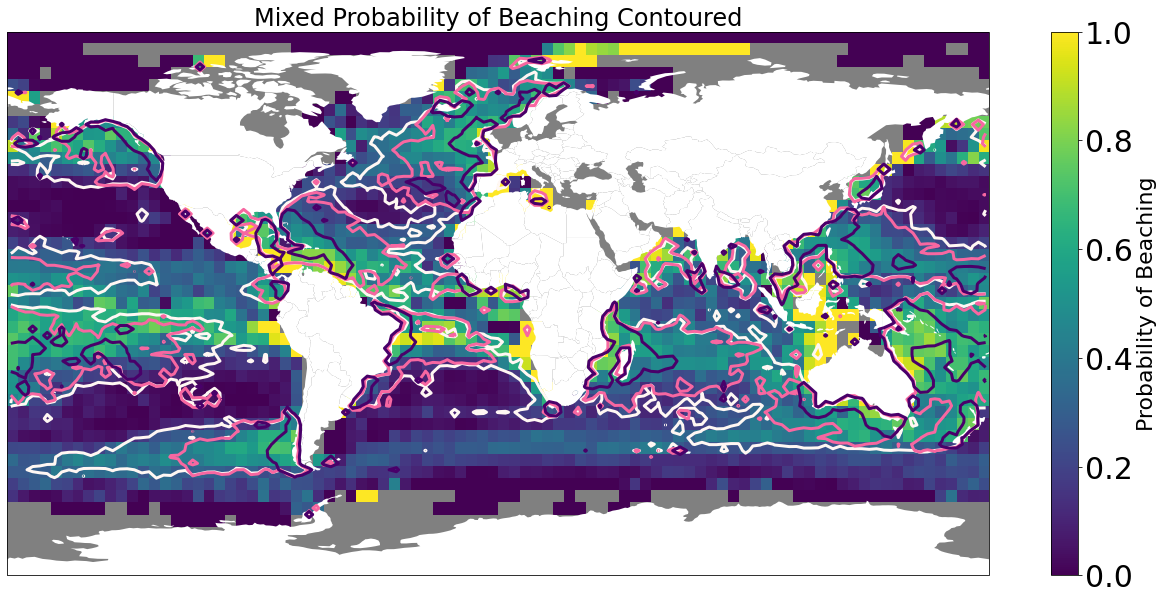

In [21]:
fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# Define the number of contours
num_contours = 3

# Generate a sequence of colors with increasing intensity from a colormap
colors = plt.cm.RdPu(np.linspace(0, 1, num_contours))

# Plot contours with specified colors
for data_normalized, color in zip([heatmap_data_normalized12,
                                   heatmap_data_normalized6,
                                   heatmap_data_normalized1], colors):
    # Add contour lines at the specified level (0.05 in this case)
    contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized,
                          levels=[0.05], colors=[color], linestyles='solid', linewidths=3,
                          transform=ccrs.PlateCarree())

    
# colormap
cmap = plt.cm.get_cmap("viridis").copy()
cmap.set_bad('grey')
# plot hist on world
mesh = plt.imshow(mixed_probability_undrogued.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(mesh, label='Probability of Beaching')
ax.set_aspect('auto')
plt.title('Mixed Probability of Beaching Contoured')

plt.show()